# **Analisi ATP**

## **Importazione dati e librerie**

### Librerie

In [ ]:
# Per importazione del dataset da Kaggle
import kagglehub

# Per la manipolazione dei dati
import pandas as pd
import numpy as np

# Per la visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Per la gestione delle date
from datetime import datetime

# Per il preprocessing e il machine learning 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
# Impostazioni grafiche per Seaborn
sns.set_theme(style="whitegrid")

# Per la manipolazione delle stringhe
import re

# Per le permutazioni
import itertools

### Import dati

In [ ]:
# importazione del dataset direttamente da Kaggle
path = kagglehub.dataset_download("dissfya/atp-tennis-2000-2023daily-pull")

In [ ]:
# lettura del csv importato, concatenado la stringa del percorso che abbiamo nella variabile path con il nome del dataset
df = pd.read_csv(path + "/atp_tennis.csv")

### Check

In [ ]:
df.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
0,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,Dosedel S.,63,77,-1,-1,-1.0,-1.0,6-4 6-2
1,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Clement A.,Enqvist T.,Enqvist T.,56,5,-1,-1,-1.0,-1.0,3-6 3-6
2,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,Escude N.,40,655,-1,-1,-1.0,-1.0,6-7 7-5 6-3
3,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Knippschild J.,Federer R.,Federer R.,87,65,-1,-1,-1.0,-1.0,1-6 4-6
4,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,Fromberg R.,81,198,-1,-1,-1.0,-1.0,7-6 5-7 6-4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65582 entries, 0 to 65581
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tournament  65582 non-null  object 
 1   Date        65582 non-null  object 
 2   Series      65582 non-null  object 
 3   Court       65582 non-null  object 
 4   Surface     65582 non-null  object 
 5   Round       65582 non-null  object 
 6   Best of     65582 non-null  int64  
 7   Player_1    65582 non-null  object 
 8   Player_2    65582 non-null  object 
 9   Winner      65582 non-null  object 
 10  Rank_1      65582 non-null  int64  
 11  Rank_2      65582 non-null  int64  
 12  Pts_1       65582 non-null  int64  
 13  Pts_2       65582 non-null  int64  
 14  Odd_1       65582 non-null  float64
 15  Odd_2       65582 non-null  float64
 16  Score       65582 non-null  object 
dtypes: float64(2), int64(5), object(10)
memory usage: 8.5+ MB


#### Cleaning

In [ ]:
# Rimuoviamo tutte le righe che contengono valori mancanti (NaN) nelle colonne fondamentali per il nostro modello.
# In questo caso consideriamo fondamentali: ranking, punti, superficie e numero di set.
df = df.dropna(subset=[
    'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2',
    'Surface', 'Best of'
])

# pulizia dal dataframe da valori non validi per i punti e per il ranking
df = df[(df['Pts_1'] > 0) & (df['Pts_2'] > 0)]
df = df[(df['Rank_1'] > 0) & (df['Rank_2'] > 0)]

# Filtriamo le partite con quote valide (diverse da -1 o -1.00)
# Alcune righe hanno valori negativi che indicano quote mancanti → le togliamo
df = df[(df['Odd_1'] > 1) & (df['Odd_2'] > 1)]

### **Trasformazione variabili**

In [ ]:
# Trasformo winner in binario
df['Winner_Player1'] = (df['Winner'] == df['Player_1']).astype(int)
# Trasformo Date in data
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

## **Manipolazione dataset**

In questa sezione Oltre all'assegnazione dei **formati** corretti alle nostre variabili, ne aggiungeremo di **nuove**, in seguito saranno utili allà addestramento del nostro modello.
nello specifico le variabili che andremo ad inseriere saranno:
- **Rank gap** 
- **Surface prolificy**
- **Tournement prolificy**

#### Trasformo Score in game player 1/2

In [ ]:
def count_games(score_str):
    try:
        score_str = re.sub(r'(RET|W/O|ABD|DEF|SUSP)', '', str(score_str), flags=re.IGNORECASE)
        score_str = score_str.strip()
        sets = re.split(r'[\n\s]+', score_str)

        p1_games = 0
        p2_games = 0

        for set_score in sets:
            if not set_score:
                continue
            set_score = re.sub(r'\(.*?\)', '', set_score)
            parts = set_score.split('-')
            if len(parts) != 2:
                continue
            g1, g2 = int(parts[0]), int(parts[1])
            p1_games += g1
            p2_games += g2

        return pd.Series([p1_games, p2_games])
    except:
        return pd.Series([np.nan, np.nan])

In [ ]:
# Calcolo games vinti dai due giocatori
df[['Games_Player1', 'Games_Player2']] = df['Score'].apply(count_games)

df

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score,Winner_Player1,Games_Player1,Games_Player2
15652,Swedish Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Robredo T.,Tabara M.,Robredo T.,20,112,1425,381,1.10,6.00,7-5 6-0,1,13,5
15653,Swedish Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Ryderstedt M.,Vinciguerra A.,Vinciguerra A.,132,917,326,9,1.66,2.10,3-6 1-6,0,4,12
15654,Swedish Open,2005-07-05,International,Outdoor,Clay,1st Round,3,Youzhny M.,Haehnel J.,Youzhny M.,27,109,1200,391,1.19,4.00,6-1 6-1,1,12,2
15655,Swedish Open,2005-07-05,International,Outdoor,Clay,1st Round,3,Dlouhy L.,Ferrero J.C.,Ferrero J.C.,136,31,315,1150,7.00,1.07,4-6 1-6,0,5,12
15656,Swedish Open,2005-07-05,International,Outdoor,Clay,1st Round,3,Berdych T.,Kim K.,Berdych T.,42,71,811,541,1.19,4.00,6-2 6-3,1,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65577,Mallorca Championships,2025-06-26,ATP250,Outdoor,Grass,Quarterfinals,3,Tien L.,Moutet C.,Moutet C.,67,83,903,739,1.75,2.10,2-6 5-7,0,7,13
65578,Mallorca Championships,2025-06-26,ATP250,Outdoor,Grass,Quarterfinals,3,Michelsen A.,Bautista Agut R.,Michelsen A.,33,43,1620,1236,1.95,1.85,6-4 7-6,1,13,10
65579,Mallorca Championships,2025-06-27,ATP250,Outdoor,Grass,Semifinals,3,Auger-Aliassime F.,Griekspoor T.,Griekspoor T.,27,34,1775,1535,1.67,2.20,4-6 4-6,0,8,12
65580,Mallorca Championships,2025-06-27,ATP250,Outdoor,Grass,Semifinals,3,Moutet C.,Michelsen A.,Moutet C.,83,33,739,1620,2.40,1.57,6-4 7-6,1,13,10


### **Aggiunta Variabili**

#### Rank Gap → Differenza di ranking tra Player_2 e Player_1

In [ ]:
df['Rank_Gap'] = df['Rank_2'] - df['Rank_1']

#### Tournement Prolificy → rendimento del giocatore nel torneo
game vinti / game totali [in quel torneo fino a quella data]

In [ ]:
# Creazione ID match e calcolo game totali
df['Match_ID'] = df.index
df['Game_Total'] = df['Games_Player1'] + df['Games_Player2']

# Preparazione dataset Player 1
df_player1 = df[['Match_ID', 'Date', 'Tournament', 'Player_1', 'Games_Player1', 'Game_Total']].copy()
df_player1['Game_Win_Rate'] = df_player1['Games_Player1'] / df_player1['Game_Total']
df_player1.rename(columns={'Player_1': 'Player'}, inplace=True)
df_player1.drop('Games_Player1', axis=1, inplace=True)

# Preparazione dataset Player 2
df_player2 = df[['Match_ID', 'Date', 'Tournament', 'Player_2', 'Games_Player2', 'Game_Total']].copy()
df_player2['Game_Win_Rate'] = df_player2['Games_Player2'] / df_player2['Game_Total']
df_player2.rename(columns={'Player_2': 'Player'}, inplace=True)
df_player2.drop('Games_Player2', axis=1, inplace=True)

# Unione datasets
df_combo = pd.concat([df_player1, df_player2], ignore_index=True)

# Ordinamento per calcoli temporali corretti
df_combo.sort_values(by=['Player', 'Tournament', 'Date', 'Match_ID'], inplace=True)

# Calcolo Tournament Prolificy per gruppo
def calculate_tournament_prolificy(group):
    group = group.copy()
    group['Tournament_Prolificy'] = group['Game_Win_Rate'].shift(1).expanding().mean()
    return group

# Applicazione calcolo per ogni combinazione Player-Tournament
df_combo = df_combo.groupby(['Player', 'Tournament'], group_keys=False).apply(calculate_tournament_prolificy)

# Ordinamento finale e pulizia
df_combo.sort_values(by=['Date', 'Match_ID'], inplace=True)
df_combo.reset_index(drop=True, inplace=True)

# Unione con il dataframe principale
# Merge per Player 1
df_player1_prolificy = df_combo[df_combo['Match_ID'].isin(df['Match_ID'])]
df = df.merge(
    df_player1_prolificy[['Match_ID', 'Player', 'Tournament_Prolificy']],
    left_on=['Match_ID', 'Player_1'],
    right_on=['Match_ID', 'Player'],
    how='left'
).drop('Player', axis=1)
df.rename(columns={'Tournament_Prolificy': 'Tournament_Prolificy_Player1'}, inplace=True)

# Merge per Player 2
df = df.merge(
    df_player1_prolificy[['Match_ID', 'Player', 'Tournament_Prolificy']],
    left_on=['Match_ID', 'Player_2'],
    right_on=['Match_ID', 'Player'],
    how='left'
).drop('Player', axis=1)
df.rename(columns={'Tournament_Prolificy': 'Tournament_Prolificy_Player2'}, inplace=True)

C:\Users\luca9\AppData\Local\Temp\ipykernel_9484\4218035209.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_combo = df_combo.groupby(['Player', 'Tournament'], group_keys=False).apply(calculate_tournament_prolificy)


In [ ]:
df = df.sort_values(by='Date')

# CORREZIONE: Ricreo Match_ID dopo l'ordinamento
df.reset_index(drop=True, inplace=True)
df['Match_ID'] = df.index

df

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,Odd_2,Score,Winner_Player1,Games_Player1,Games_Player2,Rank_Gap,Match_ID,Game_Total,Tournament_Prolificy_Player1,Tournament_Prolificy_Player2
0,Swedish Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Robredo T.,Tabara M.,Robredo T.,...,6.000,7-5 6-0,1,13,5,92,0,18,NaN,NaN
1,Hall of Fame Championships,2005-07-04,International,Outdoor,Grass,1st Round,3,Oudsema S.,Ginepri R.,Ginepri R.,...,1.120,2-6 7-6 0-6,0,9,18,-590,1,27,NaN,NaN
2,Hall of Fame Championships,2005-07-04,International,Outdoor,Grass,1st Round,3,Spadea V.,Popp A.,Spadea V.,...,1.500,4-6 6-3 6-2,1,16,11,127,2,27,NaN,NaN
3,Allianz Suisse Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Verdasco F.,Pospisil J.,Verdasco F.,...,7.305,6-2 6-4,1,12,6,373,3,18,NaN,NaN
4,Swedish Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Ryderstedt M.,Vinciguerra A.,Vinciguerra A.,...,2.100,3-6 1-6,0,4,12,785,4,16,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49673,Mallorca Championships,2025-06-27,ATP250,Outdoor,Grass,Semifinals,3,Moutet C.,Michelsen A.,Moutet C.,...,1.570,6-4 7-6,1,13,10,-50,49673,23,0.545035,0.538198
49674,Eastbourne International,2025-06-27,ATP250,Outdoor,Grass,Semifinals,3,Davidovich Fokina A.,Fritz T.,Fritz T.,...,1.330,3-6 6-3 1-6,0,10,15,-23,49674,25,0.590819,0.577741
49675,Eastbourne International,2025-06-27,ATP250,Outdoor,Grass,Semifinals,3,Brooksby J.,Humbert U.,Brooksby J.,...,1.440,6-7 6-4 6-4,1,18,15,-129,49675,33,0.530275,0.559470
49676,Eastbourne International,2025-06-28,ATP250,Outdoor,Grass,The Final,3,Fritz T.,Brooksby J.,Fritz T.,...,3.600,7-5 6-1,1,13,6,144,49676,19,0.578978,0.533311


#### Surface Prolificy → rendimento del giocatore sulla specifica superficie di gioco 
game vinti / game totali [su quella superficie fino a quella data]

In [ ]:
# Preparazione dataset Player 1
df_player1 = df[['Match_ID', 'Date', 'Surface', 'Player_1', 'Games_Player1', 'Game_Total']].copy()
df_player1['Game_Win_Rate'] = df_player1['Games_Player1'] / df_player1['Game_Total']
df_player1.rename(columns={'Player_1': 'Player'}, inplace=True)
df_player1.drop('Games_Player1', axis=1, inplace=True)

# Preparazione dataset Player 2
df_player2 = df[['Match_ID', 'Date', 'Surface', 'Player_2', 'Games_Player2', 'Game_Total']].copy()
df_player2['Game_Win_Rate'] = df_player2['Games_Player2'] / df_player2['Game_Total']
df_player2.rename(columns={'Player_2': 'Player'}, inplace=True)
df_player2.drop('Games_Player2', axis=1, inplace=True)

# Unione datasets
df_combined = pd.concat([df_player1, df_player2], ignore_index=True)

# Ordinamento per calcoli temporali corretti
df_combined.sort_values(by=['Player', 'Surface', 'Date', 'Match_ID'], inplace=True)

# Calcolo Surface Prolificy per gruppo
def calculate_surface_prolificy(group):
    group = group.copy()
    group['Surface_Prolificy'] = group['Game_Win_Rate'].shift(1).expanding().mean()
    return group

# Applicazione calcolo per ogni combinazione Player-Surface
df_combined = df_combined.groupby(['Player', 'Surface'], group_keys=False).apply(calculate_surface_prolificy)

# Ordinamento finale e pulizia
df_combined.sort_values(by=['Date', 'Match_ID'], inplace=True)
df_combined.reset_index(drop=True, inplace=True)

# Unione con il dataframe principale
# Filtro per i match presenti nel dataframe principale
df_surface_prolificy = df_combined[df_combined['Match_ID'].isin(df['Match_ID'])]

# Merge per Player 1
df = df.merge(
    df_surface_prolificy[['Match_ID', 'Player', 'Surface_Prolificy']],
    left_on=['Match_ID', 'Player_1'],
    right_on=['Match_ID', 'Player'],
    how='left'
).drop('Player', axis=1)
df.rename(columns={'Surface_Prolificy': 'Surface_Prolificy_Player1'}, inplace=True)

# Merge per Player 2
df = df.merge(
    df_surface_prolificy[['Match_ID', 'Player', 'Surface_Prolificy']],
    left_on=['Match_ID', 'Player_2'],
    right_on=['Match_ID', 'Player'],
    how='left'
).drop('Player', axis=1)
df.rename(columns={'Surface_Prolificy': 'Surface_Prolificy_Player2'}, inplace=True)

C:\Users\luca9\AppData\Local\Temp\ipykernel_9484\1000604323.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_combined = df_combined.groupby(['Player', 'Surface'], group_keys=False).apply(calculate_surface_prolificy)


In [ ]:
# Verifica che i calcoli siano corretti
print("\nVerifica per un giocatore specifico:")
sample_player = df_combined['Player'].iloc[11]
sample_surface = df_combined['Surface'].iloc[7]
subset = df_combined[(df_combined['Player'] == sample_player) & 
                    (df_combined['Surface'] == sample_surface)].head()
print(subset[['Player', 'Surface', 'Date', 'Game_Win_Rate', 'Surface_Prolificy']])


Verifica per un giocatore specifico:
       Player Surface       Date  Game_Win_Rate  Surface_Prolificy
11   Seppi A.    Clay 2005-07-05       0.512821                NaN
113  Seppi A.    Clay 2005-07-06       0.590909           0.512821
147  Seppi A.    Clay 2005-07-08       0.533333           0.551865
181  Seppi A.    Clay 2005-07-18       0.590909           0.545688
285  Seppi A.    Clay 2005-07-20       0.600000           0.556993


In [ ]:
df

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,Winner_Player1,Games_Player1,Games_Player2,Rank_Gap,Match_ID,Game_Total,Tournament_Prolificy_Player1,Tournament_Prolificy_Player2,Surface_Prolificy_Player1,Surface_Prolificy_Player2
0,Swedish Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Robredo T.,Tabara M.,Robredo T.,...,1,13,5,92,0,18,NaN,NaN,NaN,NaN
1,Hall of Fame Championships,2005-07-04,International,Outdoor,Grass,1st Round,3,Oudsema S.,Ginepri R.,Ginepri R.,...,0,9,18,-590,1,27,NaN,NaN,NaN,NaN
2,Hall of Fame Championships,2005-07-04,International,Outdoor,Grass,1st Round,3,Spadea V.,Popp A.,Spadea V.,...,1,16,11,127,2,27,NaN,NaN,NaN,NaN
3,Allianz Suisse Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Verdasco F.,Pospisil J.,Verdasco F.,...,1,12,6,373,3,18,NaN,NaN,NaN,NaN
4,Swedish Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Ryderstedt M.,Vinciguerra A.,Vinciguerra A.,...,0,4,12,785,4,16,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49673,Mallorca Championships,2025-06-27,ATP250,Outdoor,Grass,Semifinals,3,Moutet C.,Michelsen A.,Moutet C.,...,1,13,10,-50,49673,23,0.545035,0.538198,0.484788,0.527667
49674,Eastbourne International,2025-06-27,ATP250,Outdoor,Grass,Semifinals,3,Davidovich Fokina A.,Fritz T.,Fritz T.,...,0,10,15,-23,49674,25,0.590819,0.577741,0.504059,0.527928
49675,Eastbourne International,2025-06-27,ATP250,Outdoor,Grass,Semifinals,3,Brooksby J.,Humbert U.,Brooksby J.,...,1,18,15,-129,49675,33,0.530275,0.559470,0.531996,0.525268
49676,Eastbourne International,2025-06-28,ATP250,Outdoor,Grass,The Final,3,Fritz T.,Brooksby J.,Fritz T.,...,1,13,6,144,49676,19,0.578978,0.533311,0.529072,0.532788


In [ ]:
# Droppo colonne superflue
df = df.drop(columns=['Court', 'Score', 'Round', 'Winner','Match_ID'])

### Check finale

In [ ]:
df = df.sort_values(by='Date')

df

,Tournament,Date,Series,Surface,Best of,Player_1,Player_2,Rank_1,Rank_2,Pts_1,...,Odd_2,Winner_Player1,Games_Player1,Games_Player2,Rank_Gap,Game_Total,Tournament_Prolificy_Player1,Tournament_Prolificy_Player2,Surface_Prolificy_Player1,Surface_Prolificy_Player2
0,Swedish Open,2005-07-04,International,Clay,3,Robredo T.,Tabara M.,20,112,1425,...,6.000,1,13,5,92,18,NaN,NaN,NaN,NaN
1,Hall of Fame Championships,2005-07-04,International,Grass,3,Oudsema S.,Ginepri R.,693,103,22,...,1.120,0,9,18,-590,27,NaN,NaN,NaN,NaN
2,Hall of Fame Championships,2005-07-04,International,Grass,3,Spadea V.,Popp A.,49,176,730,...,1.500,1,16,11,127,27,NaN,NaN,NaN,NaN
3,Allianz Suisse Open,2005-07-04,International,Clay,3,Verdasco F.,Pospisil J.,59,432,640,...,7.305,1,12,6,373,18,NaN,NaN,NaN,NaN
4,Swedish Open,2005-07-04,International,Clay,3,Ryderstedt M.,Vinciguerra A.,132,917,326,...,2.100,0,4,12,785,16,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49673,Mallorca Championships,2025-06-27,ATP250,Grass,3,Moutet C.,Michelsen A.,83,33,739,...,1.570,1,13,10,-50,23,0.545035,0.538198,0.484788,0.527667
49674,Eastbourne International,2025-06-27,ATP250,Grass,3,Davidovich Fokina A.,Fritz T.,28,5,1770,...,1.330,0,10,15,-23,25,0.590819,0.577741,0.504059,0.527928
49675,Eastbourne International,2025-06-27,ATP250,Grass,3,Brooksby J.,Humbert U.,149,20,405,...,1.440,1,18,15,-129,33,0.530275,0.559470,0.531996,0.525268
49676,Eastbourne International,2025-06-28,ATP250,Grass,3,Fritz T.,Brooksby J.,5,149,4635,...,3.600,1,13,6,144,19,0.578978,0.533311,0.529072,0.532788


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49678 entries, 0 to 49677
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Tournament                    49678 non-null  object        
 1   Date                          49678 non-null  datetime64[ns]
 2   Series                        49678 non-null  object        
 3   Surface                       49678 non-null  object        
 4   Best of                       49678 non-null  int64         
 5   Player_1                      49678 non-null  object        
 6   Player_2                      49678 non-null  object        
 7   Rank_1                        49678 non-null  int64         
 8   Rank_2                        49678 non-null  int64         
 9   Pts_1                         49678 non-null  int64         
 10  Pts_2                         49678 non-null  int64         
 11  Odd_1                         496

In [ ]:
unique_tournaments = sorted(df['Tournament'].unique())
print(unique_tournaments)


['ABN AMRO World Tennis Tournament', 'AEGON Championships', 'AEGON International', 'AEGON Open', 'AIG Japan Open Tennis Championships', 'ASB Classic', 'ATP Vegeta Croatia Open', 'Abierto Mexicano', 'Abierto Mexicano Mifel', 'Adelaide International', 'Adelaide International 1', 'Adelaide International 2', 'Allianz Suisse Open', 'Almaty Open', 'Antalya Open', 'AnyTech365 Andalucia Open', 'Apia International', 'Argentina Open', 'Astana Open', 'Atlanta Open', 'Atlanta Tennis Championships', 'Australian Open', 'Austrian Open', 'BA-CA Tennis Trophy', 'BB&T Atlanta Open', 'BMW Open', 'BNP Paribas', 'BNP Paribas Masters', 'BNP Paribas Open', 'BRD Nastase Tiriac Trophy', 'Barcelona Open', 'Belgrade Open', 'Bet-At-Home Cup', 'Brasil Open', 'Brisbane International', "Campionati Internazional d'Italia", 'Campionati Internazionali Di Sicilia', 'Canadian Open', 'Catella Swedish Open', 'Channel Open', 'Chengdu Open', 'Chennai Open', 'Chile Open', 'China Open', 'Citi Open', 'Claro Open Colombia', 'Cop

## **Analisi preliminari**


#### Analisi di correlazione

In [ ]:
# Analisi di correlazione tra Winner_Player1 e tutte le altre variabili numeriche

# Selezioniamo solo le colonne numeriche
numeric_cols = df.select_dtypes(include=['number']).columns

# Calcoliamo la correlazione di Winner_Player1 con tutte le altre variabili numeriche
correlations = df[numeric_cols].corr()['Winner_Player1'].sort_values(ascending=False)

# Visualizziamo la correlazione
print("Correlazione di Winner_Player1 con le altre variabili numeriche:")
print(correlations)


Correlazione di Winner_Player1 con le altre variabili numeriche:
Winner_Player1                  1.000000
Games_Player1                   0.486092
Odd_2                           0.319754
Rank_Gap                        0.236743
Pts_1                           0.205758
Surface_Prolificy_Player1       0.188583
Rank_2                          0.158677
Tournament_Prolificy_Player1    0.063905
Best of                         0.000048
Game_Total                     -0.000808
Tournament_Prolificy_Player2   -0.073050
Rank_1                         -0.165578
Surface_Prolificy_Player2      -0.185599
Pts_2                          -0.209513
Odd_1                          -0.323408
Games_Player2                  -0.487239
Name: Winner_Player1, dtype: float64


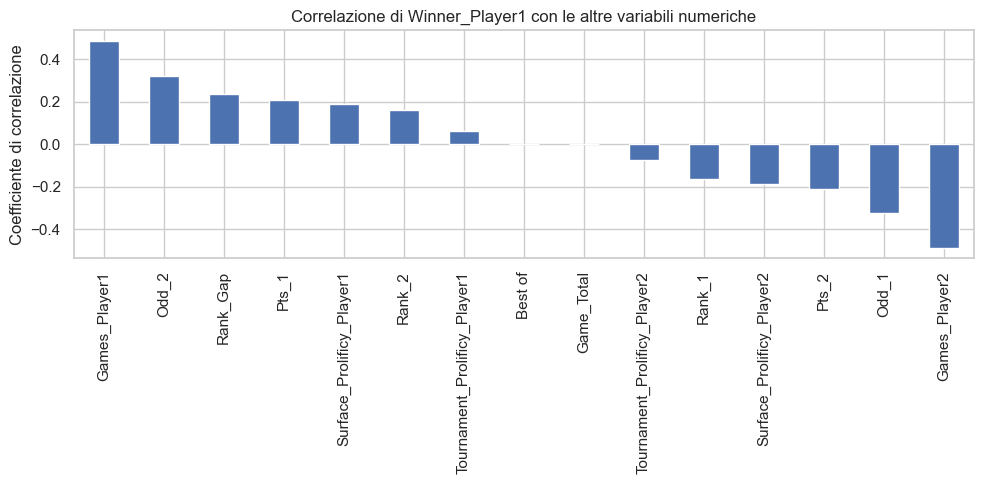

In [ ]:
# Visualizzazione grafica delle correlazioni (escludendo Winner_Player1 stesso)
correlations.drop('Winner_Player1').plot(kind='bar', figsize=(10,5))
plt.title('Correlazione di Winner_Player1 con le altre variabili numeriche')
plt.ylabel('Coefficiente di correlazione')
plt.tight_layout()
plt.show()

##### Le variabili che più influenzano la vittoria del Player1 sono le quote dei bookmaker (Odd_1 e Odd_2), il gap di ranking e i punti dei giocatori. Le altre variabili hanno un impatto molto basso o trascurabile sulla probabilità di vittoria del Player1.

## **Analisi Predittiva**

#### Random Forest

### **Preparazione dati**

In [ ]:
# Selezione features ed encoding delle variabili categoriche

feature_raw = [
    'Pts_1', 'Pts_2', 'Rank_Gap', 'Surface_Prolificy_Player1',
       'Surface_Prolificy_Player2', 'Tournament_Prolificy_Player1',
       'Tournament_Prolificy_Player2'
]

features = pd.get_dummies(df[feature_raw])

# Costruzione della matrice X e del target y

X = features.dropna()
y = df.loc[X.index, 'Winner_Player1']

# Divisione in dati di addestramento e di test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32
)

### **Creazione e addestramento del modello**

In [ ]:
# Creiamo un modello di classificazione Random Forest con 1000 alberi decisionali.

model = RandomForestClassifier(n_estimators=4000, max_depth = 8, random_state=115)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=4000, random_state=115)

### **Valutazione e Analisi del modello**

#### Valutazione training

In [ ]:
# Valutazione sul training set
y_train_pred = model.predict(X_train)
print(f"\nAccuratezza sul training set: {accuracy_score(y_train, y_train_pred):.2%}")
print("Report di classificazione (train):")
print(classification_report(y_train, y_train_pred))


Accuratezza sul training set: 70.74%
Report di classificazione (train):
              precision    recall  f1-score   support

           0       0.71      0.71      0.71     13098
           1       0.71      0.71      0.71     13135

    accuracy                           0.71     26233
   macro avg       0.71      0.71      0.71     26233
weighted avg       0.71      0.71      0.71     26233



#### Cross Validation

In [ ]:
scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Accuratezza media cross-validation: {scores.mean():.2%}")
print(f"Deviazione standard: {scores.std():.2%}")

Accuratezza media cross-validation: 67.61%
Deviazione standard: 0.43%


#### Valuztazione test

In [ ]:
# Valutazione del modello
# Usiamo il modello per fare previsioni sulle partite del test set.
# Poi calcoliamo l’accuratezza e stampiamo un report dettagliato con le metriche di classificazione.
y_pred = model.predict(X_test)

print(f"Accuratezza sul test set: {accuracy_score(y_test, y_pred):.2%}")
print("\nReport di classificazione:")
print(classification_report(y_test, y_pred))

Accuratezza sul test set: 68.27%

Report di classificazione:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      3244
           1       0.68      0.69      0.69      3315

    accuracy                           0.68      6559
   macro avg       0.68      0.68      0.68      6559
weighted avg       0.68      0.68      0.68      6559



#### AUC e ROC

AUC Score: 0.752


c:\Users\luca9\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


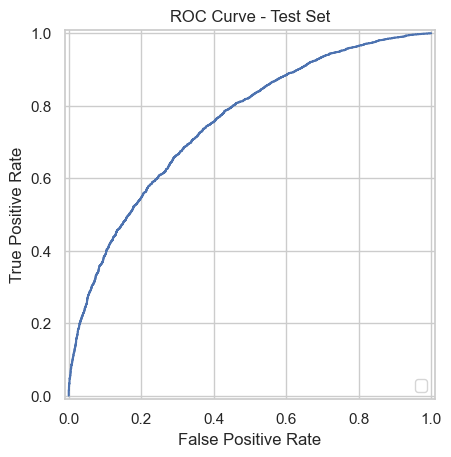

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Probabilità predette dal modello sul test set
y_proba = model.predict_proba(X_test)[:, 1]

# Calcolo ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score:.3f}")

# Visualizzazione ROC Curve
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve - Test Set")
plt.show()

#### Calibrazione probabilistica

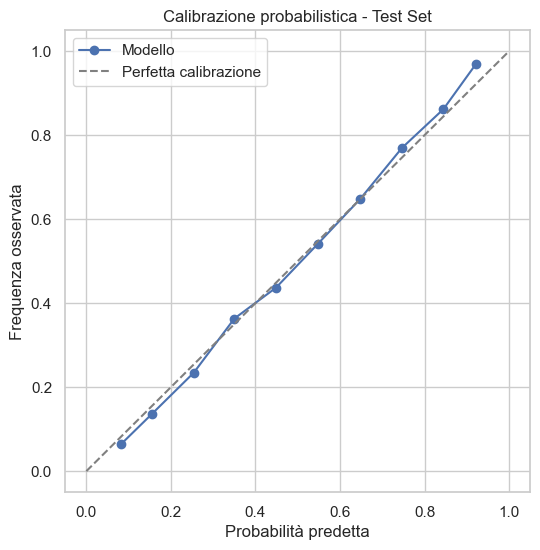

In [ ]:
from sklearn.calibration import calibration_curve

# Calcolo curva di calibrazione (10 bin uniformi)
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')

# Visualizzazione grafica
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Modello')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfetta calibrazione')
plt.xlabel('Probabilità predetta')
plt.ylabel('Frequenza osservata')
plt.title('Calibrazione probabilistica - Test Set')
plt.legend()
plt.grid(True)
plt.show()

#### Commento

##### Valutazione del modello

La fase di testing ha permesso di verificare le performance del modello.

- Il modello ha mostrato un’**accuratezza coerente** con quella osservata durante la validazione incrociata, indicando una buona **capacità di generalizzazione**.
- Le metriche ottenute sul test set sono molto simili a quelle del training set, suggerendo che il modello **non presenta segnali di overfitting**.
- Il **report di classificazione** evidenzia un bilanciamento tra precision, recall e f1-score per entrambe le classi, senza squilibri marcati.
- La **ROC Curve** conferma la capacità del modello di discriminare correttamente tra le due classi a diversi livelli di soglia decisionale.
- Il valore di **AUC superiore a 0.7** rafforza l’affidabilità del modello in termini di distinzione tra classi positive e negative.
- La **curva di calibrazione** mostra una corrispondenza molto vicina alla calibrazione ideale, indicando che le probabilità predette sono **attendibili e ben calibrate**.

In sintesi, la valutazione sul test set conferma che il modello è **stabile**, **robusto**, **non sovradattato** e fornisce **probabilità interpretabili**, rendendolo adatto ad applicazioni predittive in contesti reali.

### Confronto con altri modelli

#### Dummy classifier

In [ ]:
   from sklearn.dummy import DummyClassifier
   dummy = DummyClassifier(strategy='most_frequent')
   dummy.fit(X_train, y_train)
   print("DummyClassifier accuracy:", dummy.score(X_test, y_test))

DummyClassifier accuracy: 0.505412410428419


#### Gradient Boosting

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

c:\Users\luca9\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:18:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Testing
y_pred = xgb.predict(X_test)
print(f"Accuracy XGBoost: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred))

Accuracy XGBoost: 0.668
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      3244
           1       0.67      0.67      0.67      3315

    accuracy                           0.67      6559
   macro avg       0.67      0.67      0.67      6559
weighted avg       0.67      0.67      0.67      6559



#### Commento

Il confronto con altri modelli ha evidenziato che la Random Forest si comporta meglio rispetto sia al Dummy Classifier (baseline) che all’XGBoost.  
Il modello di base (Dummy) conferma che le feature contengono informazione utile, mentre XGBoost – seppur potente – non ha superato la Random Forest in questa configurazione.  
Questa analisi rafforza la scelta del modello principale, che risulta il più adatto per il task e il dataset considerato.

### Analisi degli errori

#### Commento

La matrice di confusione mostra un **modello bilanciato** con **1561 sconfitte** e **1488 vittorie** predette correttamente, **670 falsi negativi** e **690 falsi positivi**. L'analisi degli errori rivela che **il modello sbaglia** principalmente quando il **Rank_Gap è vicino a zero**, cioè quando gli atleti hanno ranking simili. Questo comportamento è logico: è più difficile predire l'esito di una partita tra atleti di livello simile rispetto a match con grandi differenze di ranking.

### **Analisi influenza features**

In [ ]:
importanza_serie = pd.Series(model.feature_importances_, index=X_train.columns)
importanza_df = importanza_serie.sort_values(ascending=False).reset_index()
importanza_df.columns = ['Variabile', 'Importanza']
print("Tabella importanza variabili nel modello Random Forest:")
print(importanza_df)

Tabella importanza variabili nel modello Random Forest:
                      Variabile  Importanza
0                      Rank_Gap    0.336389
1                         Pts_2    0.163228
2                         Pts_1    0.162479
3     Surface_Prolificy_Player2    0.125038
4     Surface_Prolificy_Player1    0.120190
5  Tournament_Prolificy_Player2    0.050016
6  Tournament_Prolificy_Player1    0.042662


<Figure size 1000x600 with 0 Axes>

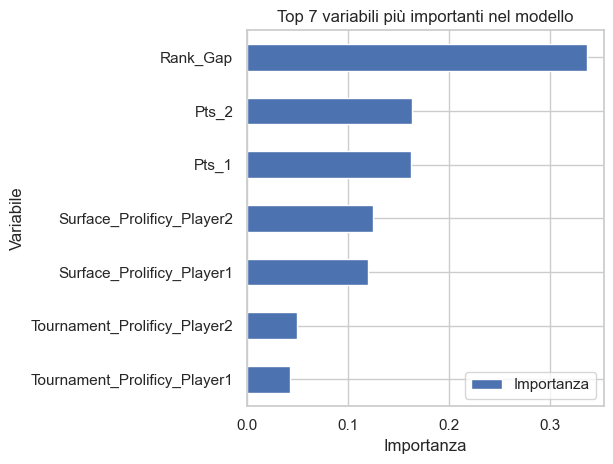

In [ ]:
# Ordinamento delle variabili per importanza decrescente e selezione delle prime 7
top_features = importanza_df.sort_values(by='Importanza', ascending=False).head(7)

# Visualizzazione grafica
plt.figure(figsize=(10, 6))
top_features.plot(x='Variabile', y='Importanza', kind='barh', legend=True)
plt.title("Top 7 variabili più importanti nel modello")
plt.xlabel("Importanza")
plt.ylabel("Variabile")
plt.gca().invert_yaxis()  # Inverte l'asse Y per mostrare la più importante in alto
plt.tight_layout()
plt.show()

#### Commento

L'analisi dell'importanza delle feature conferma che **Rank_Gap è il fattore dominante** nella predizione, seguito dai **punti dei giocatori**. **Le prolificità sulla superficie contribuiscono moderatamente**, **mentre le prolificità sui tornei hanno impatto minimo**.

### Analisi Degli Errori

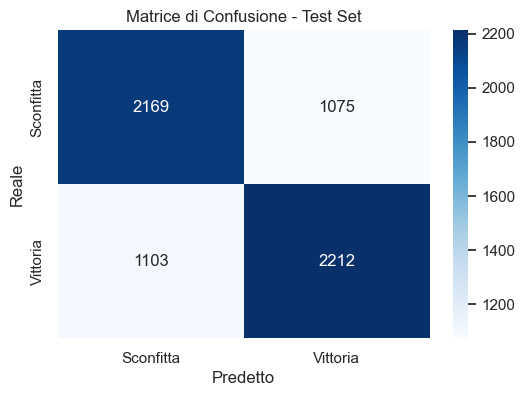

Numero di errori sul test set: 2178
Esempi di errori del modello:


,Tournament,Date,Player_1,Player_2,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Rank_Gap,Winner_Player1,Predetto,Reale
35913,Wimbledon,2019-07-04,Isner J.,Kukushkin M.,12,58,2715,885,1.25,4.00,46,0,1,0
38772,Miami Open,2021-04-03,Hurkacz H.,Rublev A.,37,8,1645,5101,4.33,1.22,-29,1,0,1
44149,Internazionali BNL d'Italia,2023-05-12,Van De Zandschulp B.,Djere L.,30,62,1250,825,1.91,1.91,32,0,1,0
29713,Memphis Open,2017-02-18,Kukushkin M.,Basilashvili N.,103,67,573,714,2.10,1.72,-36,0,1,0
1172,BNP Paribas,2005-11-06,Ljubicic I.,Berdych T.,10,50,1765,725,1.28,3.50,40,0,1,0
24419,Australian Open,2015-01-19,Vesely J.,Troicki V.,39,54,985,826,2.10,1.66,15,0,1,0
2032,U.S. Men's Clay Court Championships,2006-04-15,Haas T.,Roddick A.,27,4,1250,2655,1.80,1.90,-23,1,0,1
41558,Mutua Madrid Open,2022-05-05,Auger-Aliassime F.,Sinner J.,10,12,3625,3015,2.37,1.57,2,1,0,1
45094,US Open,2023-08-28,Cachin P.,Shelton B.,66,47,822,1015,5.00,1.17,-19,0,1,0
38258,Murray River Open,2021-02-05,Berankis R.,Vesely J.,72,69,889,928,1.80,2.00,-3,0,1,0


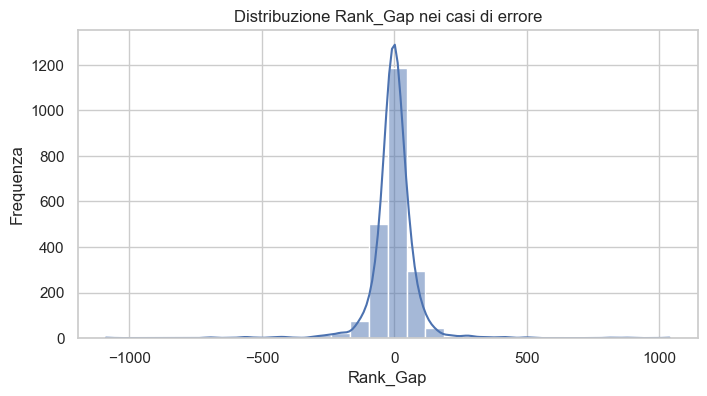

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sconfitta', 'Vittoria'], yticklabels=['Sconfitta', 'Vittoria'])
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Matrice di Confusione - Test Set')
plt.show()

# Analisi degli errori: vediamo alcuni esempi di predizioni errate
errori = X_test.copy()
errori['Reale'] = y_test
errori['Predetto'] = y_pred
errori = errori[errori['Reale'] != errori['Predetto']]

print(f"Numero di errori sul test set: {len(errori)}")
print("Esempi di errori del modello:")
display(df.loc[errori.index, [
    'Tournament', 'Date', 'Player_1', 'Player_2', 'Rank_1', 'Rank_2', 
    'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Rank_Gap', 'Winner_Player1'
]].assign(
    Predetto=errori['Predetto'].values, 
    Reale=errori['Reale'].values
).head(10))

# Analisi: distribuzione degli errori rispetto al gap di ranking
plt.figure(figsize=(8,4))
sns.histplot(errori['Rank_Gap'], bins=30, kde=True)
plt.title('Distribuzione Rank_Gap nei casi di errore')
plt.xlabel('Rank_Gap')
plt.ylabel('Frequenza')
plt.show()


#### Commento

L’analisi degli errori mostra che il modello **sbaglia principalmente nei match equilibrati**, dove il **divario di ranking tra i giocatori è ridotto**. La **matrice di confusione** conferma un **buon bilanciamento** tra falsi positivi e negativi, mentre gli esempi concreti evidenziano situazioni ambigue o difficili da prevedere. Questa sezione rafforza la lettura delle performance, evidenziando i limiti fisiologici del modello in contesti incerti.

## **Calcolo accuratezza bookmakers**


#### Preparazione dati

#### **Calcolo accuratezza** sui dati di test

In [ ]:
feature_raw = [
    'Odd_1', 'Odd_2'
]
features = pd.get_dummies(df[feature_raw])
# Costruzione della matrice X e del target y
# X contiene tutte le righe complete delle feature selezionate.
# y è la nostra variabile da predire, ovvero Winner_Player1.
X = features.dropna()
y = df.loc[X.index, 'Winner_Player1']

# Divisione in dati di addestramento e di test
# Usiamo un random_state per prendere gli stassi valori del nostro modello
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32
)
df1 = X_test.join(y_test)

# Crea una colonna 'FavoriteP1' che vale 1 se la quota di Player_1 è più bassa di quella di Player_2, altrimenti 0
df1['FavoriteP1'] = np.where(df1['Odd_1'] < df1['Odd_2'], 1, 0)

#  Verifica se il favorito ha vinto (con parentesi corrette)
df1['Bookmaker_Correct'] = np.where(df1['FavoriteP1'] == df1['Winner_Player1'], 1, 0)

# Calcola l'accuratezza dei bookmaker sui dati di test
bookmaker_accuracy_test = df1['Bookmaker_Correct'].mean()

print(f"Accuratezza Bookmaker sui dati di test: {bookmaker_accuracy_test:.4f} ({bookmaker_accuracy_test*100:.2f}%)")
print(f"Numero di match nel test set: {len(df1)}")
print(f"Previsioni corrette: {df1['Bookmaker_Correct'].sum()}")

Accuratezza Bookmaker sui dati di test: 0.7016 (70.16%)
Numero di match nel test set: 9936
Previsioni corrette: 6971


**Il valore è prossimo a quello del nopstro modello**


## **Previsione Scontri diretti ATP Top 10**

### Preparazione dati

In [ ]:
# URL della pagina Wikipedia con la tabella deil Rank ATP
url = "https://it.wikipedia.org/wiki/Classifica_ATP"

# Legge tutte le tabelle della pagina
tables = pd.read_html(url)

# Seleziona la tabella giusta (la seconda nel nostro caso, indice 1)
df_rank = tables[1]

# Rinomina colonne per uniformità, la colonna rinominata Temp è una colonna non visibile nella pagina web 
df_rank.columns = ['Rank', 'Giocatore', 'Punti', 'Variazione', 'Temp']

# Pulisce i nomi
df_rank['Giocatore'] = df_rank['Giocatore'].str.replace(r"\s*\(.*?\)", "", regex=True) # Rimuove la parte del testo tra parentesi, che contiene la nazionalità, ad esempio: "Jannik Sinner (ITA)" diventa "Jannik Sinner".
df_rank['Giocatore'] = df_rank['Giocatore'].str.replace(r".*? ", "", regex=True) #Rimuove qualsiasi parte del nome che viene prima dello spazio (come la bandiera o il paese). Ad esempio, "Italia (bandiera) Jannik Sinner" 
                                                                                 #diventa solo "Jannik Sinner".

# Rimuove spazi non visibili (come &nbsp;) e altri caratteri non numerici
df_rank['Punti'] = df_rank['Punti'].astype(str).str.replace(r'\xa0', '', regex=True).str.replace(' ', '').str.replace('.', '', regex=False).astype(int)

# Seleziona la Top 10
top10 = df_rank[['Rank', 'Giocatore', 'Punti']].head(10)
top10.columns = ['Rank', 'Name', 'Pts']

top10

,Rank,Name,Pts
0,1,Sinner,10880
1,2,Alcaraz,8850
2,3,Zverev,6385
3,4,Draper,4800
4,5,Đoković,4630
5,6,Musetti,4560
6,7,Fritz,4485
7,8,Paul,3510
8,9,Rune,3440
9,10,Minaur,3285


#### Rinomino alcuni giocatori 

In [ ]:
# Rinomina 'Đoković' in 'Djokovic' nella colonna 'Name' di top10
top10['Name'] = top10['Name'].replace({'Đoković': 'Djokovic'})

# Rinomina 'De Minaur' in 'Minaur' nella colonna 'Player' di df_combined
df_combined['Player'] = df_combined['Player'].replace({'De Minaur A.': 'Minaur'})

#### Inserimento della surf. prolificy 


In [ ]:
# 1. Estrai cognomi da df_combined (serve per avere lo stesso formato dell'altro dtaset)
df_combined['Surname'] = df_combined['Player'].apply(lambda x: x.split()[0].rstrip('.') if isinstance(x, str) else x)

# 2. Trova match con top10
top10_names = top10['Name'].tolist()
matching_players = [player for player in top10_names if player in df_combined['Surname'].values]

# 3. Estrai dati più recenti per ogni giocatore-superficie
surface_data = df_combined[df_combined['Surname'].isin(matching_players)][
    ['Surname', 'Surface', 'Surface_Prolificy', 'Date']
].copy()

# Converti Date
surface_data['Date'] = pd.to_datetime(surface_data['Date'])

# Prendi solo valori più recenti
surface_latest = surface_data.loc[
    surface_data.groupby(['Surname', 'Surface'])['Date'].idxmax()
][['Surname', 'Surface', 'Surface_Prolificy']]

# 4. Pivot: una colonna per superficie
surface_pivot = surface_latest.pivot(
    index='Surname', 
    columns='Surface', 
    values='Surface_Prolificy'
).fillna(0)

# Rinomina colonne
surface_pivot.columns = [f"Surface_Prolificy_{col}" for col in surface_pivot.columns]
surface_pivot = surface_pivot.reset_index()

# 5. Merge con top10
top10 = top10.merge(surface_pivot, left_on='Name', right_on='Surname', how='left')
top10 = top10.drop('Surname', axis=1)

#### Tournament prolificy

In [ ]:
# Rimuovi colonne duplicate se esistono
columns_to_drop = [col for col in top10.columns if 'Tournament_Prolificy_Wimbledon' in col]
if columns_to_drop:
    top10 = top10.drop(columns_to_drop, axis=1)

def find_best_match(top10_name, df_combo):
    # Prima prova match esatto del cognome
    exact_matches = df_combo[df_combo['Player'].str.split(' ').str[0] == top10_name]['Player'].unique()
    if len(exact_matches) > 0:
        return exact_matches[0]
    
    # Poi prova match parziale
    partial_matches = df_combo[df_combo['Player'].str.contains(top10_name, case=False, na=False)]['Player'].unique()
    if len(partial_matches) > 0:
        return min(partial_matches, key=len)
    
    return None

# Trova corrispondenze
top10_names = top10['Name'].tolist()
matching_players_final = {}
for name in top10_names:
    best_match = find_best_match(name, df_combo)
    if best_match:
        matching_players_final[name] = best_match

# Estrai dati Wimbledon
matching_players_list = list(matching_players_final.values())
tournament_data = df_combo[
   (df_combo['Player'].isin(matching_players_list)) & 
   (df_combo['Tournament'] == 'Wimbledon')
][['Player', 'Tournament_Prolificy', 'Date']].copy()

# Inizializza colonna con 0.5
top10['Tournament_Prolificy_Wimbledon'] = 0.5

# Aggiorna con dati reali se esistono
if len(tournament_data) > 0:
    tournament_data['Date'] = pd.to_datetime(tournament_data['Date'])
    tournament_latest = tournament_data.loc[
       tournament_data.groupby('Player')['Date'].idxmax()
    ][['Player', 'Tournament_Prolificy']]
    
    for _, row in tournament_latest.iterrows():
        df_player_name = row['Player']
        for top10_name, df_name in matching_players_final.items():
            if df_name == df_player_name:
                mask = top10['Name'] == top10_name
                top10.loc[mask, 'Tournament_Prolificy_Wimbledon'] = row['Tournament_Prolificy']
                break

In [ ]:
top10

,Rank,Name,Pts,Surface_Prolificy_Carpet,Surface_Prolificy_Clay,Surface_Prolificy_Grass,Surface_Prolificy_Hard,Tournament_Prolificy_Wimbledon
0,1,Sinner,10880,0.000000,0.575996,0.556832,0.582533,0.580532
1,2,Alcaraz,8850,0.000000,0.606190,0.578197,0.578441,0.569731
2,3,Zverev,6385,0.511903,0.558063,0.551766,0.551137,0.459559
3,4,Draper,4800,0.000000,0.566001,0.542984,0.584331,0.470285
4,5,Djokovic,4630,0.517938,0.603221,0.606100,0.615318,0.608968
5,6,Musetti,4560,0.000000,0.547099,0.519727,0.490783,0.539513
6,7,Fritz,4485,0.000000,0.517957,0.529072,0.536217,0.543943
7,8,Paul,3510,0.000000,0.514080,0.553596,0.531860,0.607312
8,9,Rune,3440,0.000000,0.537642,0.524093,0.526210,0.541696
9,10,Minaur,3285,0.000000,0.523769,0.543007,0.540641,0.539530


### **Creazione combinazioni e stima quote**

In [ ]:
# Recupera le colonne richieste dal modello
required_columns = model.feature_names_in_

# Inizializza sempre una lista vuota per evitare accumuli
combinations = []

# Ciclo su tutte le possibili combinazioni di top10
for player_1, player_2 in itertools.permutations(top10.to_dict('records'), 2):
    
    # Crea la riga con tutti i valori richiesti per Player_1 vs Player_2
    row_ab = {
        'Pts_1': player_1['Pts'],
        'Pts_2': player_2['Pts'],
        'Rank_Gap': player_2['Rank'] - player_1['Rank'],
        'Surface_Prolificy_Player1': player_1['Surface_Prolificy_Grass'],
        'Surface_Prolificy_Player2': player_2['Surface_Prolificy_Grass'],
        'Tournament_Prolificy_Player1': player_1.get('Tournament_Prolificy_Wimbledon', 0.5),
        'Tournament_Prolificy_Player2': player_2.get('Tournament_Prolificy_Wimbledon', 0.5)
    }

    row_ab = {col: row_ab.get(col, 0) for col in required_columns}
    X_ab = pd.DataFrame([row_ab], columns=required_columns)
    prob_ab = model.predict_proba(X_ab)[0][1]

    # Costruzione anche della riga invertita Player_2 vs Player_1
    row_ba = {
        'Pts_1': player_2['Pts'],
        'Pts_2': player_1['Pts'],
        'Rank_Gap': player_1['Rank'] - player_2['Rank'],
        'Surface_Prolificy_Player1': player_2['Surface_Prolificy_Grass'],
        'Surface_Prolificy_Player2': player_1['Surface_Prolificy_Grass'],
        'Tournament_Prolificy_Player1': player_2.get('Tournament_Prolificy_Wimbledon', 0.5),
        'Tournament_Prolificy_Player2': player_1.get('Tournament_Prolificy_Wimbledon', 0.5)
    }

    row_ba = {col: row_ba.get(col, 0) for col in required_columns}
    X_ba = pd.DataFrame([row_ba], columns=required_columns)
    prob_ba = model.predict_proba(X_ba)[0][1]

    # --- MEDIA SIMMETRICA DELLE DUE PREVISIONI ---
    # Questo passaggio garantisce che: Prob(P1 vs P2) ≈ 1 - Prob(P2 vs P1)
    # così da evitare piccole differenze dovute alla struttura asimmetrica del modello
    prob_p1 = (prob_ab + (1 - prob_ba)) / 2
    prob_p2 = 1 - prob_p1

    # Quote attese
    odd_1_estimated = 1 / prob_p1 if prob_p1 > 0 else float('inf')
    odd_2_estimated = 1 / prob_p2 if prob_p2 > 0 else float('inf')

    combinations.append({
        'Player_1': player_1['Name'],
        'Player_2': player_2['Name'],
        'Prob_P1': prob_p1,
        'Prob_P2': prob_p2,
        'Odd_1_Estimated': odd_1_estimated,
        'Odd_2_Estimated': odd_2_estimated
    })

# Creazione di un DataFrame con le combinazioni
combinations_df = pd.DataFrame(combinations)

combinations_df

,Player_1,Player_2,Prob_P1,Prob_P2,Odd_1_Estimated,Odd_2_Estimated
0,Sinner,Alcaraz,0.450354,0.549646,2.220475,1.819353
1,Sinner,Zverev,0.604388,0.395612,1.654566,2.527731
2,Sinner,Draper,0.659944,0.340056,1.515280,2.940693
3,Sinner,Djokovic,0.506153,0.493847,1.975689,2.024917
4,Sinner,Musetti,0.665534,0.334466,1.502552,2.989845
...,...,...,...,...,...,...
85,Minaur,Djokovic,0.210250,0.789750,4.756240,1.266224
86,Minaur,Musetti,0.437509,0.562491,2.285666,1.777807
87,Minaur,Fritz,0.437171,0.562829,2.287435,1.776738
88,Minaur,Paul,0.408070,0.591930,2.450560,1.689389


In [ ]:
combinations_df['Prob_P1'] = combinations_df['Prob_P1'].round(2)
combinations_df['Prob_P2'] = combinations_df['Prob_P2'].round(2)
combinations_df['Odd_1_Estimated'] = combinations_df['Odd_1_Estimated'].round(2)
combinations_df['Odd_2_Estimated'] = combinations_df['Odd_2_Estimated'].round(2)
combinations_df

,Player_1,Player_2,Prob_P1,Prob_P2,Odd_1_Estimated,Odd_2_Estimated
0,Sinner,Alcaraz,0.45,0.55,2.22,1.82
1,Sinner,Zverev,0.60,0.40,1.65,2.53
2,Sinner,Draper,0.66,0.34,1.52,2.94
3,Sinner,Djokovic,0.51,0.49,1.98,2.02
4,Sinner,Musetti,0.67,0.33,1.50,2.99
...,...,...,...,...,...,...
85,Minaur,Djokovic,0.21,0.79,4.76,1.27
86,Minaur,Musetti,0.44,0.56,2.29,1.78
87,Minaur,Fritz,0.44,0.56,2.29,1.78
88,Minaur,Paul,0.41,0.59,2.45,1.69


In [ ]:
# Verifica le probabilità di vittoria Sinner vs Alcaraz e Alcaraz vs Sinner

# Trova la riga Sinner vs Alcaraz
sinner_alcaraz = combinations_df[
    (combinations_df['Player_1'] == 'Sinner') & (combinations_df['Player_2'] == 'Alcaraz')
]

# Trova la riga Alcaraz vs Sinner
alcaraz_sinner = combinations_df[
    (combinations_df['Player_1'] == 'Alcaraz') & (combinations_df['Player_2'] == 'Sinner')
]

print("Sinner vs Alcaraz:")
print(sinner_alcaraz[['Player_1', 'Player_2', 'Prob_P1', 'Prob_P2', 'Odd_1_Estimated', 'Odd_2_Estimated']])

print("\nAlcaraz vs Sinner:")
print(alcaraz_sinner[['Player_1', 'Player_2', 'Prob_P1', 'Prob_P2', 'Odd_1_Estimated', 'Odd_2_Estimated']])


Sinner vs Alcaraz:
  Player_1 Player_2  Prob_P1  Prob_P2  Odd_1_Estimated  Odd_2_Estimated
0   Sinner  Alcaraz     0.45     0.55             2.22             1.82

Alcaraz vs Sinner:
  Player_1 Player_2  Prob_P1  Prob_P2  Odd_1_Estimated  Odd_2_Estimated
9  Alcaraz   Sinner     0.55     0.45             1.82             2.22


### Costruisco altri dataset utili alla successiva visualizzazione in Tableau

#### Face to Face win rate 

In [ ]:
# Creiamo un DataFrame con tutti gli accoppiamenti possibili e il win rate di ciascun giocatore contro l'altro

winrate_results = []

for index, combination_row in combinations_df.iterrows():
    p1 = combination_row['Player_1']
    p2 = combination_row['Player_2']
    
    # Trova tutte le partite tra p1 e p2 (in entrambi gli ordini)
    mask = (
        ((df['Player_1'].str.contains(p1, na=False)) & (df['Player_2'].str.contains(p2, na=False))) |
        ((df['Player_1'].str.contains(p2, na=False)) & (df['Player_2'].str.contains(p1, na=False)))
    )
    h2h_matches = df[mask]
    
    total_matches = len(h2h_matches)
    if total_matches == 0:
        winrate_1 = None
        winrate_2 = None
        wins_1 = 0
        wins_2 = 0
    else:
        # Conta le vittorie di p1 e p2
        wins_1 = 0
        wins_2 = 0
        for _, match in h2h_matches.iterrows():
            # Determina chi è il vincitore
            if match['Winner_Player1'] == 1:
                winner = match['Player_1']
            else:
                winner = match['Player_2']
            # Assegna la vittoria al giusto player
            if p1 in winner:
                wins_1 += 1
            elif p2 in winner:
                wins_2 += 1
        winrate_1 = wins_1 / total_matches if total_matches > 0 else None
        winrate_2 = wins_2 / total_matches if total_matches > 0 else None

    winrate_results.append({
        'Player_1': p1,
        'Player_2': p2,
        'Total_Matches': total_matches,
        'Wins_1': wins_1,
        'Wins_2': wins_2,
        'WinRate_1': winrate_1,
        'WinRate_2': winrate_2
    })

winrate_df = pd.DataFrame(winrate_results)
winrate_df

,Player_1,Player_2,Total_Matches,Wins_1,Wins_2,WinRate_1,WinRate_2
0,Sinner,Alcaraz,12,4,8,0.333333,0.666667
1,Sinner,Zverev,7,3,4,0.428571,0.571429
2,Sinner,Draper,2,1,1,0.500000,0.500000
3,Sinner,Djokovic,8,4,4,0.500000,0.500000
4,Sinner,Musetti,2,2,0,1.000000,0.000000
...,...,...,...,...,...,...,...
85,Minaur,Djokovic,2,0,2,0.000000,1.000000
86,Minaur,Musetti,4,1,3,0.250000,0.750000
87,Minaur,Fritz,7,4,3,0.571429,0.428571
88,Minaur,Paul,6,5,1,0.833333,0.166667


#### Storico vittorie annuali players

In [ ]:
# Per ogni giocatore della top 10, estrai la percentuale di vittoria annua (generale, non solo H2H) dal dataframe df

# Estrai la lista dei top 10
top10_players = top10['Name'].tolist()

# Crea un dizionario per salvare le percentuali di vittoria annue per ogni giocatore
winrate_per_year = {}

for player in top10_players:
    # Filtra tutte le partite in cui il giocatore ha partecipato (usando str.contains!)
    mask = (df['Player_1'].str.contains(player, na=False)) | (df['Player_2'].str.contains(player, na=False))
    player_matches = df[mask].copy()
    
    if len(player_matches) == 0:
        print(f"Nessuna partita trovata per {player}")
        continue
        
    # Estrai l'anno dalla data
    player_matches['Year'] = player_matches['Date'].dt.year
    
    # Calcola vittorie per ogni anno
    def is_win(row):
        if player in row['Player_1'] and row['Winner_Player1'] == 1:
            return 1
        if player in row['Player_2'] and row['Winner_Player1'] == 0:
            return 1
        return 0
    
    player_matches['Win'] = player_matches.apply(is_win, axis=1)
    
    # Raggruppa per anno e calcola la percentuale di vittorie
    yearly_stats = player_matches.groupby('Year').agg(
        Matches=('Win', 'count'),
        Wins=('Win', 'sum')
    )
    yearly_stats['WinRate'] = yearly_stats['Wins'] / yearly_stats['Matches']
    winrate_per_year[player] = yearly_stats['WinRate']

# Crea un DataFrame riassuntivo: righe = anni, colonne = giocatori, valori = winrate
winrate_annual_df = pd.DataFrame(winrate_per_year)
print(winrate_annual_df)

        Sinner   Alcaraz    Zverev    Draper  Djokovic   Musetti     Fritz  \
Year                                                                         
2005       NaN       NaN       NaN       NaN  0.500000       NaN       NaN   
2006       NaN       NaN  0.500000       NaN  0.687500       NaN       NaN   
2007       NaN       NaN  0.466667       NaN  0.783133       NaN       NaN   
2008       NaN       NaN  0.444444       NaN  0.782609       NaN       NaN   
2009       NaN       NaN  0.411765       NaN  0.826087       NaN       NaN   
2010       NaN       NaN  0.433333       NaN  0.757143       NaN       NaN   
2011       NaN       NaN  0.100000       NaN  0.940299       NaN       NaN   
2012       NaN       NaN  0.000000       NaN  0.844156       NaN       NaN   
2013       NaN       NaN  0.400000       NaN  0.876712       NaN       NaN   
2014       NaN       NaN  0.400000       NaN  0.880597       NaN       NaN   
2015       NaN       NaN  0.456522       NaN  0.930233       NaN

### Export dati

In [ ]:
top10.to_csv("top10.csv", index=False)
combinations_df.to_csv('prob_Wimbledon.csv', index=False)
winrate_df.to_csv('winrate.csv', index=False)
winrate_annual_df.to_csv('winrate_annual.csv')